### 1: Import Libraries


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, kurtosis

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from statsmodels.tools.sm_exceptions import ValueWarning

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GroupNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import Huber
from tcn import TCN

import shap
import gc
import joblib
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ValueWarning)

import os
import sys
print(sys.executable)

b:\DCU\Practicum\Proj\App\venv_3_11\Scripts\python.exe


b:\DCU\Practicum\Proj\App\venv_3_11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2: Load and Explore Dataset

In [2]:
multimodal = pd.read_csv("train_dataset.csv", parse_dates=["Date"])
multimodal.drop(columns=['Next_Close', 'Next_3_Close', 'Next_7_Close'], inplace=True)
multimodal.head()

,Date,Open,High,Low,Close,Volume,Adj Close,Log_Returns,Volatility_Log_10,cl-op,...,total_prediction_intent,total_fear_intent,total_greed_intent,total_question_intent,total_action_intent,sentiment_minus_uncertainty,sentiment_minus_fear,sentiment_minus_action,sentiment_minus_urgency,sentiment_minus_prediction
0,2008-08-08,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,-0.004085,0.168436,302.230468,...,0.166667,0.166667,0.25,0.545455,0.625,0.238850,-0.094484,-1.011150,-0.261150,-0.094484
1,2008-08-11,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609,0.011943,0.192941,52.679687,...,0.000000,0.166667,0.00,0.363636,0.375,-0.513462,-0.180129,-0.596796,-0.346796,0.153204
2,2008-08-12,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727,0.009451,0.188543,-139.230468,...,0.000000,0.000000,0.00,0.545455,0.375,-0.666667,0.000000,-0.750000,-0.500000,0.000000
3,2008-08-13,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961,-0.007168,0.189348,-99.849609,...,0.166667,0.000000,0.25,0.454545,0.625,0.000000,0.000000,-1.250000,0.000000,-0.333333
4,2008-08-14,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688,-0.003778,0.208874,83.859376,...,0.500000,0.333333,0.25,0.454545,0.375,-0.536607,-0.536607,-0.619940,-0.869940,-0.869940


In [3]:
multimodal.shape

(1591, 53)

In [4]:
missing_values = multimodal.isnull().sum()
print("\nMissing values per column:")
missing_values[missing_values > 0]


Missing values per column:


Series([], dtype: int64)

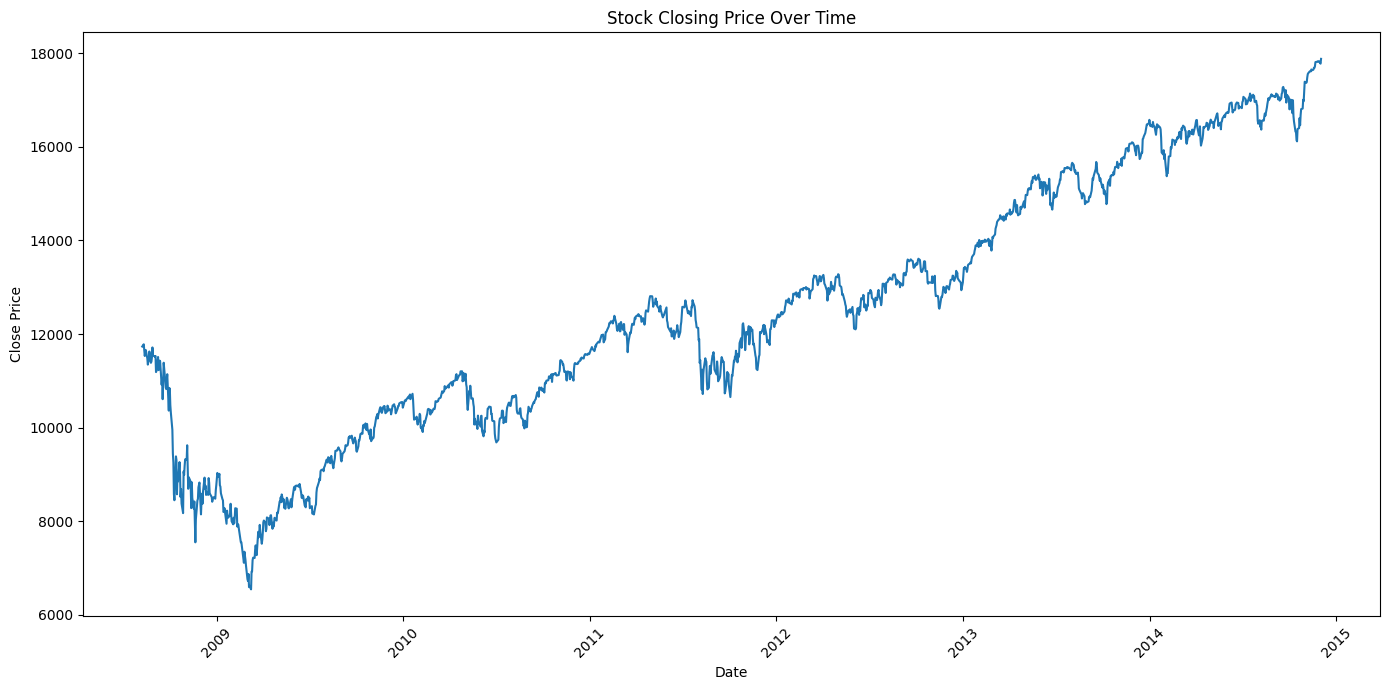

In [5]:
plt.figure(figsize=(14, 7))
plt.plot(pd.to_datetime(multimodal['Date']), multimodal['Close'])
plt.title('Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("B:/DCU/Practicum/Proj/Outputs/closing_price_plot.png")
plt.show()

### 3: Data Preprocessing

In [6]:
df_targets = multimodal[["Date", "Target", "Label", "Close"]].copy()

df_arima = multimodal[["Date", "Close"]].copy()
df_arima.set_index("Date", inplace=True)

drop_cols_lstm = ["Date", "Label", "Target"]
df_lstm = multimodal.drop(columns=drop_cols_lstm).copy()

drop_cols_tcn = ["Date", "Label", "Target"]
df_tcn = multimodal.drop(columns=drop_cols_tcn).copy()

In [7]:
# Function to clear TensorFlow memory before running any model so that the model doesnt predict on cached data
def clear_tf_memory():
    K.clear_session()
    gc.collect()

### 4: ARIMA Model

In [8]:
result = adfuller(df_arima["Close"])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: 0.49003049114940356
p-value: 0.9845669104126585


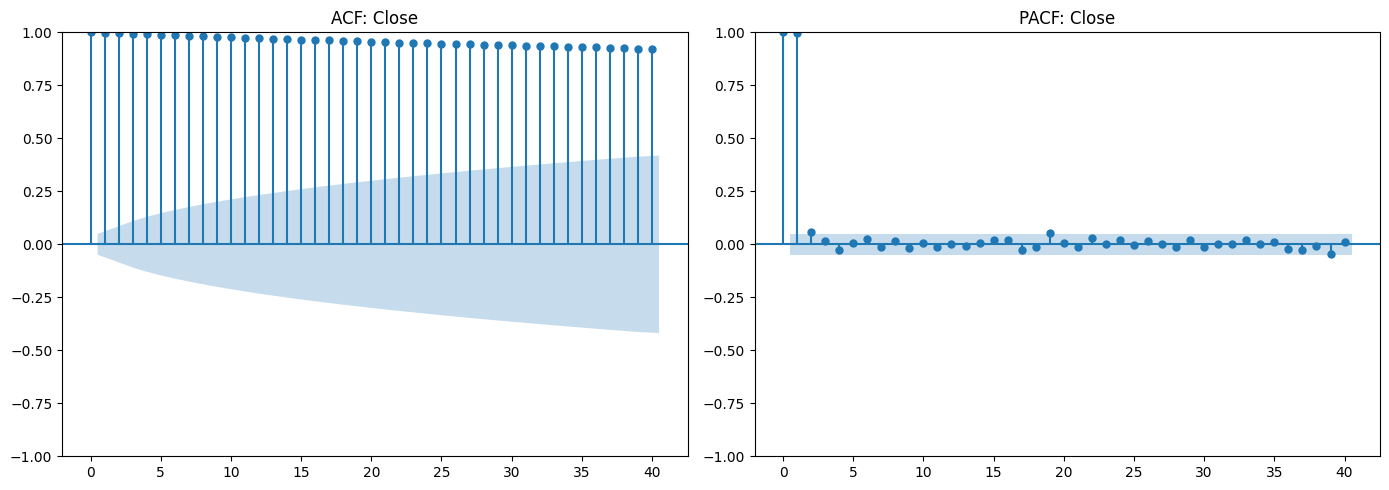

In [9]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plot_acf(df_arima["Close"], lags=40, ax=plt.gca())
plt.title("ACF: Close")

plt.subplot(1, 2, 2)
plot_pacf(df_arima["Close"], lags=40, ax=plt.gca(), method='ywm')
plt.title("PACF: Close")

plt.tight_layout()
plt.savefig("B:/DCU/Practicum/Proj/Outputs/arima_acf_pacf.png")
plt.show()


Index(['Close'], dtype='object')
ARIMA Forecast Horizon = 1
R² = 0.9921, RMSE = 238.87, MAE = 136.61


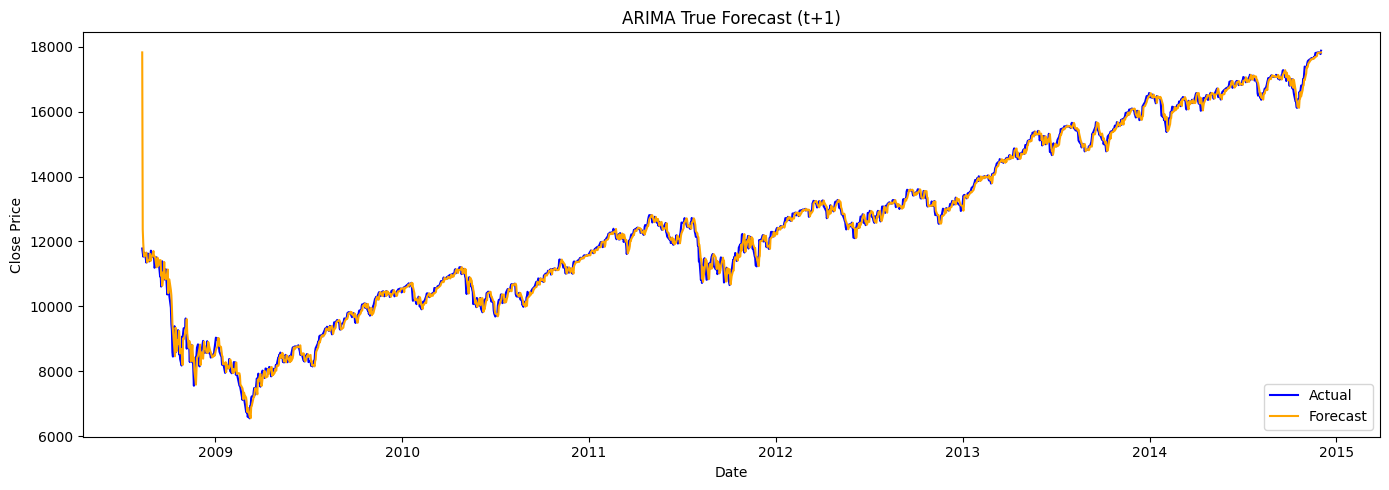

Model saved to B:/DCU/Practicum/Proj/Models\arima_t_plus_1.pkl
Index(['Close'], dtype='object')
ARIMA Forecast Horizon = 3
R² = 0.9877, RMSE = 297.54, MAE = 190.21


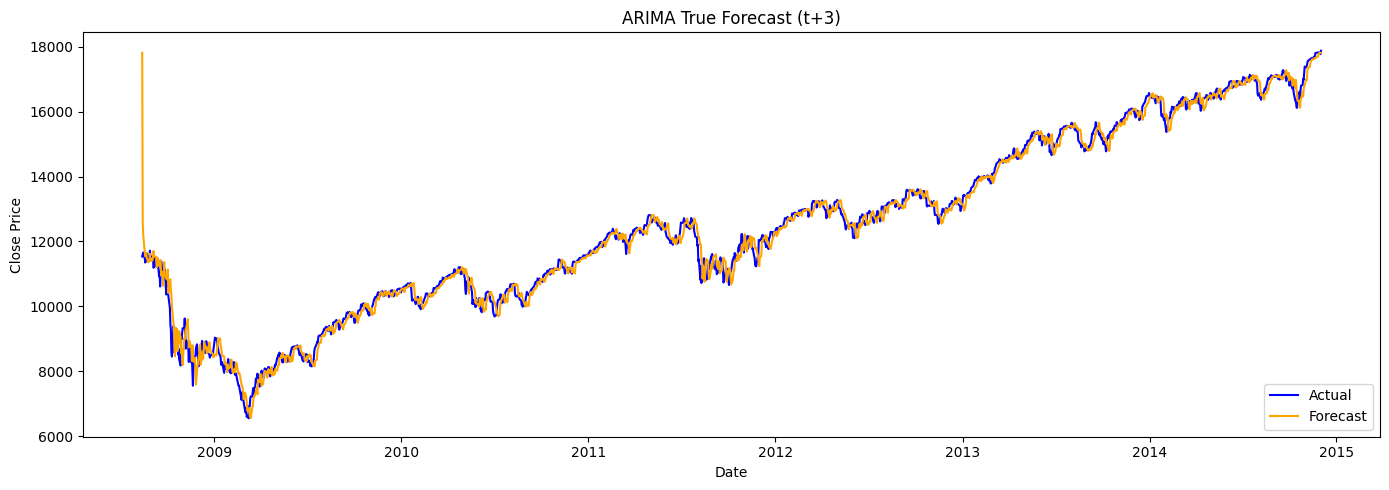

Model saved to B:/DCU/Practicum/Proj/Models\arima_t_plus_3.pkl
Index(['Close'], dtype='object')
ARIMA Forecast Horizon = 7
R² = 0.9800, RMSE = 380.06, MAE = 260.24


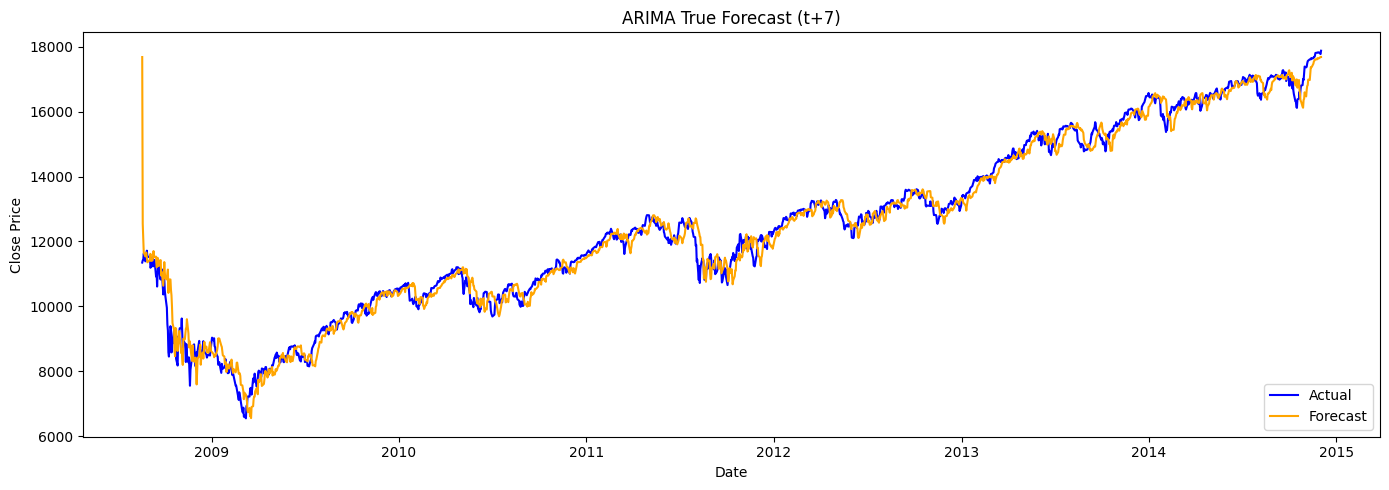

Model saved to B:/DCU/Practicum/Proj/Models\arima_t_plus_7.pkl


In [10]:
def arima_true_forecast(df_arima, forecast_horizon=1, order=(1, 1, 1), save_dir=None, plot=True):
    print(df_arima.columns)
    close_series = df_arima['Close'].values
    history = close_series[:-(forecast_horizon + 1)].tolist()
    y_true = []
    y_pred = []

    for t in range(len(close_series) - forecast_horizon):
        try:
            model = ARIMA(history, order=order).fit()
            forecast = model.forecast(steps=forecast_horizon)
            y_pred.append(forecast[-1])
            y_true.append(close_series[t + forecast_horizon])
        except:
            y_pred.append(np.nan)
            y_true.append(np.nan)
        history.append(close_series[t])

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    date_series = df_arima.index[forecast_horizon : forecast_horizon + len(y_true)]

    # Metrics
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    print(f"ARIMA Forecast Horizon = {forecast_horizon}")
    print(f"R² = {r2:.4f}, RMSE = {rmse:.2f}, MAE = {mae:.2f}")

    if plot:
        plt.figure(figsize=(14, 5))
        plt.plot(date_series, y_true, label='Actual', color='blue')
        plt.plot(date_series ,y_pred, label='Forecast', color='orange')
        plt.title(f"ARIMA True Forecast (t+{forecast_horizon})")
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"B:/DCU/Practicum/Proj/Outputs/arima_train_t_plus_{forecast_horizon}.png")
        plt.show()

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        model = ARIMA(close_series.tolist(), order=order).fit()
        save_path = os.path.join(save_dir, f'arima_t_plus_{forecast_horizon}.pkl')
        joblib.dump(model, save_path)
        print(f"Model saved to {save_path}")

    return {
        "horizon": forecast_horizon,
        "r2": r2,
        "rmse": rmse,
        "mae": mae
    }

results = []
for h in [1, 3, 7]:
    clear_tf_memory()
    res = arima_true_forecast(df_arima, forecast_horizon=h, order=(1,1,1), save_dir="B:/DCU/Practicum/Proj/Models")
    results.append(res)


## LSTM Model


Training LSTM (Single) model for horizon t+1
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0427 - val_loss: 0.0370
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0146 - val_loss: 0.0056
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0089 - val_loss: 0.0039
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0084 - val_loss: 0.0033
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0061 - val_loss: 0.0031
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0058 - val_loss: 0.0016
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0053 - val_loss: 0.0014
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0048 - val_loss: 0.0016
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0039 - val_loss: 0.0013
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0039 - val_loss: 0.0017
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0037 - val_loss: 0.0017
Epoch 12/50
44/44

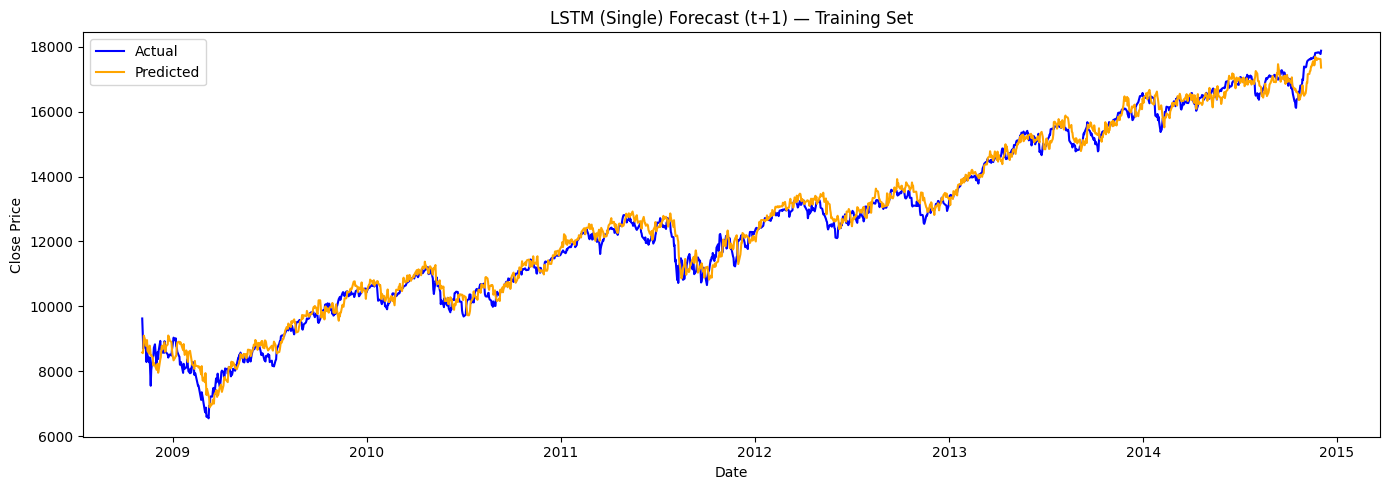


Training LSTM (Single) model for horizon t+3
Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0490 - val_loss: 0.0317
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0130 - val_loss: 0.0048
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0119 - val_loss: 0.0041
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0100 - val_loss: 0.0033
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0080 - val_loss: 0.0035
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0071 - val_loss: 0.0040
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0066 - val_loss: 0.0021
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0056 - val_loss: 0.0011
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0052 - val_loss: 9.8040e-04
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0046 - val_loss: 9.2705e-04
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0042 - val_loss: 9.5220e-04
Epoch

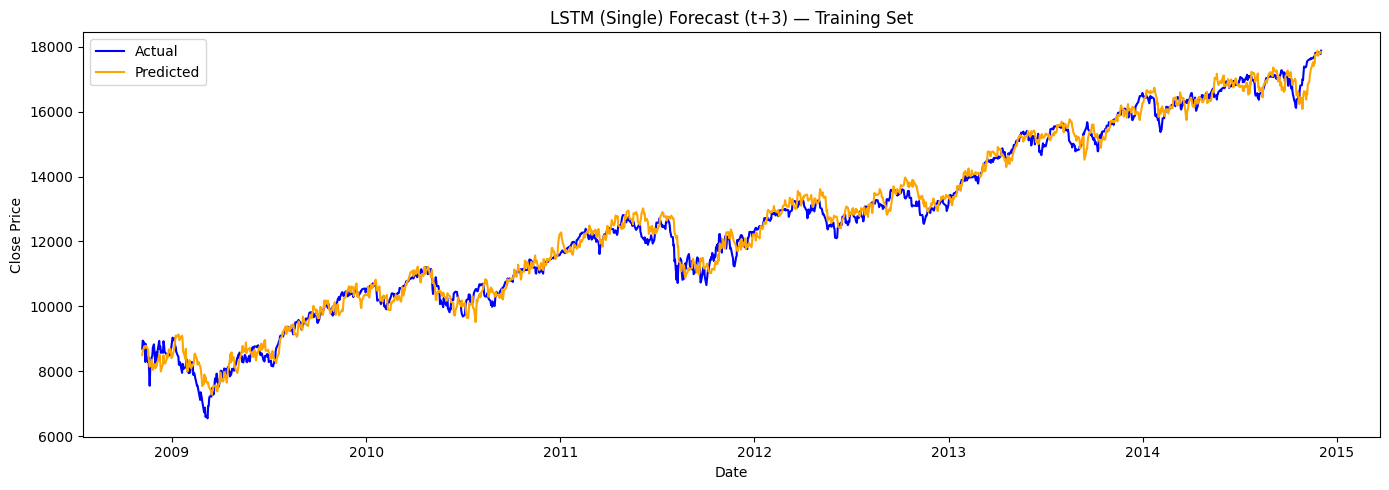


Training LSTM (Single) model for horizon t+7
Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0637 - val_loss: 0.0921
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0210 - val_loss: 0.0226
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0087 - val_loss: 0.0042
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0072 - val_loss: 0.0046
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0060 - val_loss: 0.0033
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0058 - val_loss: 0.0034
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0048 - val_loss: 0.0053
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0045 - val_loss: 0.0034
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0041 - val_loss: 0.0031
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0044 - val_loss: 0.0028
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 12/50
43/43

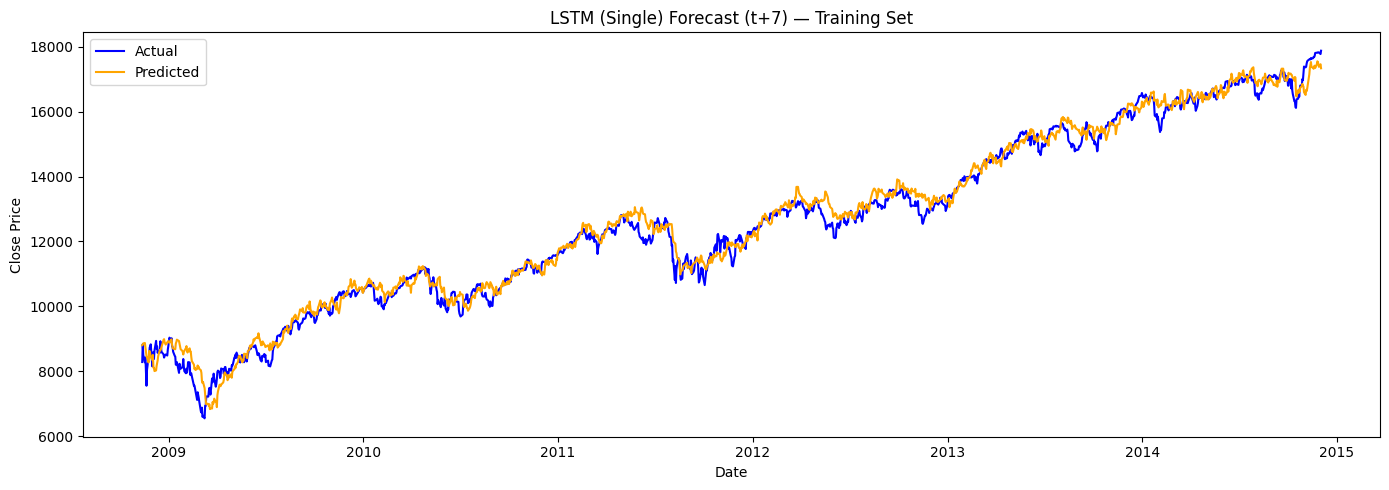


Training LSTM (Stacked) model for horizon t+1
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1739 - val_loss: 0.0531
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0360 - val_loss: 0.0362
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0209 - val_loss: 0.0116
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0158 - val_loss: 0.0086
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0150 - val_loss: 0.0080
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0134 - val_loss: 0.0057
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0130 - val_loss: 0.0074
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0113 - val_loss: 0.0058
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0118 - val_loss: 0.0052
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0118 - val_loss: 0.0067
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0106 - val_loss: 0.0085
Epoch 12/50
44/4

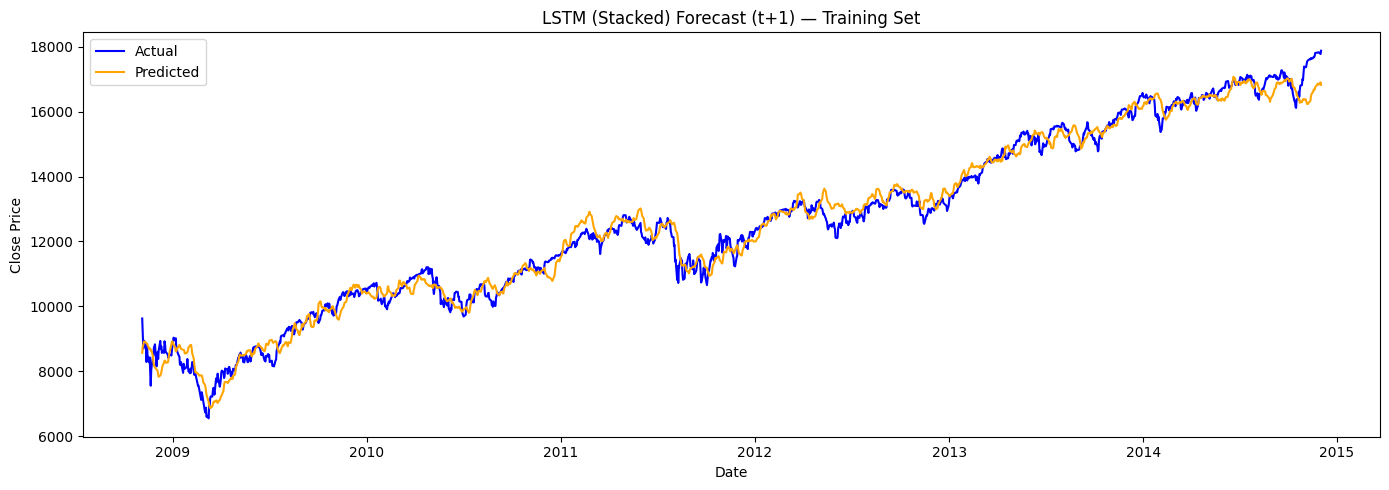


Training LSTM (Stacked) model for horizon t+3
Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0749 - val_loss: 0.0647
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0342 - val_loss: 0.0112
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0212 - val_loss: 0.0064
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0176 - val_loss: 0.0072
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0149 - val_loss: 0.0052
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0135 - val_loss: 0.0051
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0125 - val_loss: 0.0038
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0132 - val_loss: 0.0035
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0118 - val_loss: 0.0047
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0108 - val_loss: 0.0038
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0112 - val_loss: 0.0048
Epoch 12/50
43/4

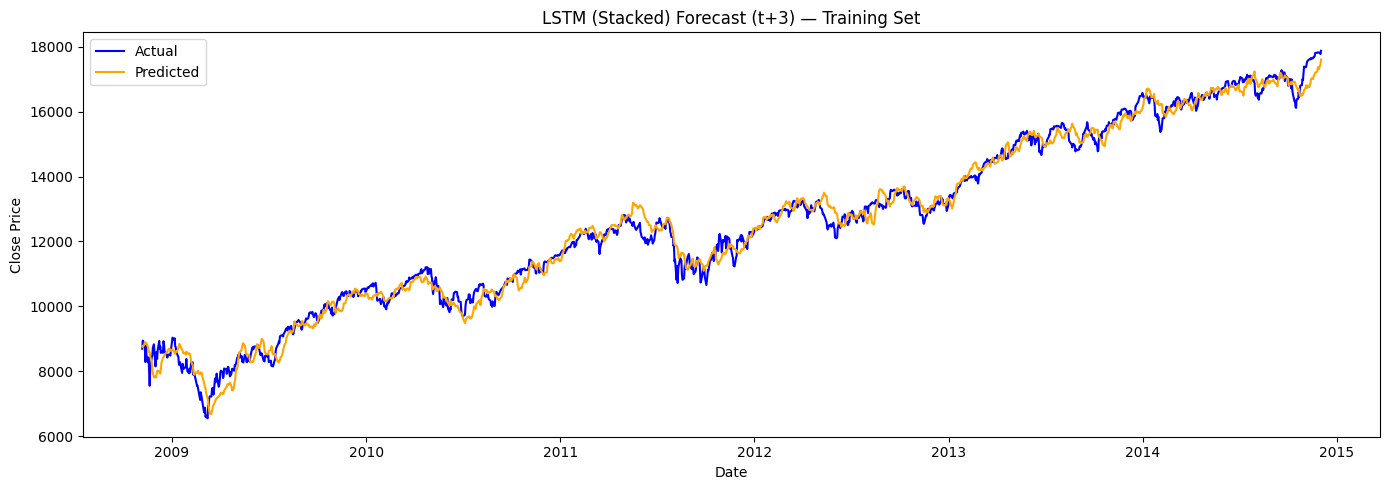


Training LSTM (Stacked) model for horizon t+7
Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0723 - val_loss: 0.0758
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0271 - val_loss: 0.0129
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0178 - val_loss: 0.0084
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0166 - val_loss: 0.0050
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0141 - val_loss: 0.0062
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0149 - val_loss: 0.0042
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0126 - val_loss: 0.0066
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0132 - val_loss: 0.0043
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0122 - val_loss: 0.0043
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0118 - val_loss: 0.0059
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0116 - val_loss: 0.0069
Saved model and 

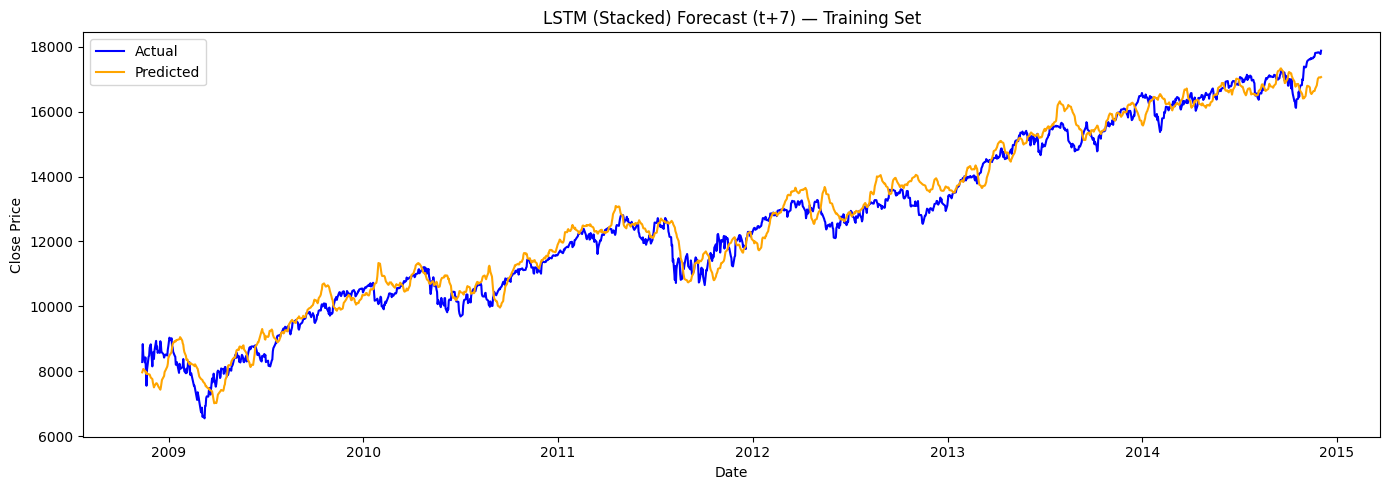

In [13]:
def train_lstm_multistep(df_lstm, forecast_horizon=1, window_size=60, epochs=50, batch_size=32, stacked=False):
    print(f"\nTraining LSTM ({'Stacked' if stacked else 'Single'}) model for horizon t+{forecast_horizon}")

    close_values = df_lstm['Close'].values

    # Scale input and output
    X_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    X_scaled = X_scaler.fit_transform(df_lstm.values)
    y_scaled = y_scaler.fit_transform(close_values.reshape(-1, 1))

    # Create sequences
    X_seq, y_seq = [], []
    for i in range(window_size, len(X_scaled) - forecast_horizon):
        X_seq.append(X_scaled[i - window_size:i])
        y_seq.append(y_scaled[i + forecast_horizon])
    X_seq, y_seq = np.array(X_seq), np.array(y_seq)

    X_train, y_train = X_seq, y_seq

    # Build model
    model = Sequential()

    if stacked:
        reg = l2(1e-5)
        model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]),
                   kernel_regularizer=reg, recurrent_regularizer=reg))
        model.add(Dropout(0.3))
        model.add(LSTM(32, kernel_regularizer=reg, recurrent_regularizer=reg))
        model.add(Dropout(0.3))
    else:
        model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(0.1))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='mse')
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=1
    )

    # Save model and scalers
    model_name = f"lstm_tplus{forecast_horizon}{'_stacked' if stacked else '_simple'}"
    base_path = "B:/DCU/Practicum/Proj/Models"
    os.makedirs(base_path, exist_ok=True)

    model.save(f"{base_path}/{model_name}.keras")
    joblib.dump(X_scaler, f"{base_path}/{model_name}_scalerX.pkl")
    joblib.dump(y_scaler, f"{base_path}/{model_name}_scalerY.pkl")

    # Save feature list
    feature_columns = df_lstm.columns.tolist()
    joblib.dump(feature_columns, f"{base_path}/{model_name}_features.pkl")
    print(f"Saved model and scalers: {model_name}")

    # Predict on train set to evaluate
    y_pred_scaled = model.predict(X_train)
    y_pred = y_scaler.inverse_transform(y_pred_scaled)
    y_true = y_scaler.inverse_transform(y_train.reshape(-1, 1))

    date_series = multimodal['Date'].iloc[window_size + forecast_horizon : window_size + forecast_horizon + len(y_pred)]

    # Metrics
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"Train R²: {r2:.4f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

    # Plot
    plt.figure(figsize=(14, 5))
    plt.plot(date_series, y_true, label='Actual', color='blue')
    plt.plot(date_series, y_pred, label='Predicted', color='orange')
    plt.title(f"LSTM ({'Stacked' if stacked else 'Single'}) Forecast (t+{forecast_horizon}) — Training Set")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"B:/DCU/Practicum/Proj/Outputs/lstm_train_t_plus_{forecast_horizon}{'_stacked' if stacked else '_simple'}.png")
    plt.show()

    return model, {"r2": r2, "rmse": rmse, "mae": mae}


for horizon in [1, 3, 7]:
    clear_tf_memory()
    train_lstm_multistep(df_lstm, forecast_horizon=horizon, stacked=False)

for horizon in [1, 3, 7]:
    clear_tf_memory()
    train_lstm_multistep(df_lstm, forecast_horizon=horizon, stacked=True)

## Temporal Convolutional Networks

In [15]:
Dropped_tcn_cols = [
    'Open', 'High', 'Low', 'Volume', 'Adj Close',
    'Volatility_Log_10', 'cl-op', 'hi-lo', 'pct_change',
    'total_buying_intent', 'total_prediction_intent'
]
df_tcn_filtered = df_tcn.drop(columns=Dropped_tcn_cols).copy()


Training TCN model to predict Log Returns at t+1
Starting model.fit()
Epoch 1/50
44/44 - 4s - 102ms/step - loss: 0.4008 - val_loss: 0.0530
Epoch 2/50
44/44 - 0s - 11ms/step - loss: 0.3013 - val_loss: 0.0229
Epoch 3/50
44/44 - 0s - 11ms/step - loss: 0.2594 - val_loss: 0.0144
Epoch 4/50
44/44 - 0s - 11ms/step - loss: 0.2413 - val_loss: 0.0122
Epoch 5/50
44/44 - 0s - 11ms/step - loss: 0.2120 - val_loss: 0.0110
Epoch 6/50
44/44 - 0s - 11ms/step - loss: 0.2001 - val_loss: 0.0075
Epoch 7/50
44/44 - 0s - 11ms/step - loss: 0.1776 - val_loss: 0.0055
Epoch 8/50
44/44 - 0s - 11ms/step - loss: 0.1722 - val_loss: 0.0054
Epoch 9/50
44/44 - 0s - 10ms/step - loss: 0.1519 - val_loss: 0.0056
Epoch 10/50
44/44 - 0s - 11ms/step - loss: 0.1408 - val_loss: 0.0034
Epoch 11/50
44/44 - 0s - 11ms/step - loss: 0.1413 - val_loss: 0.0021
Epoch 12/50
44/44 - 0s - 11ms/step - loss: 0.1349 - val_loss: 0.0019
Epoch 13/50
44/44 - 0s - 10ms/step - loss: 0.1249 - val_loss: 0.0018
Epoch 14/50
44/44 - 0s - 10ms/step - los

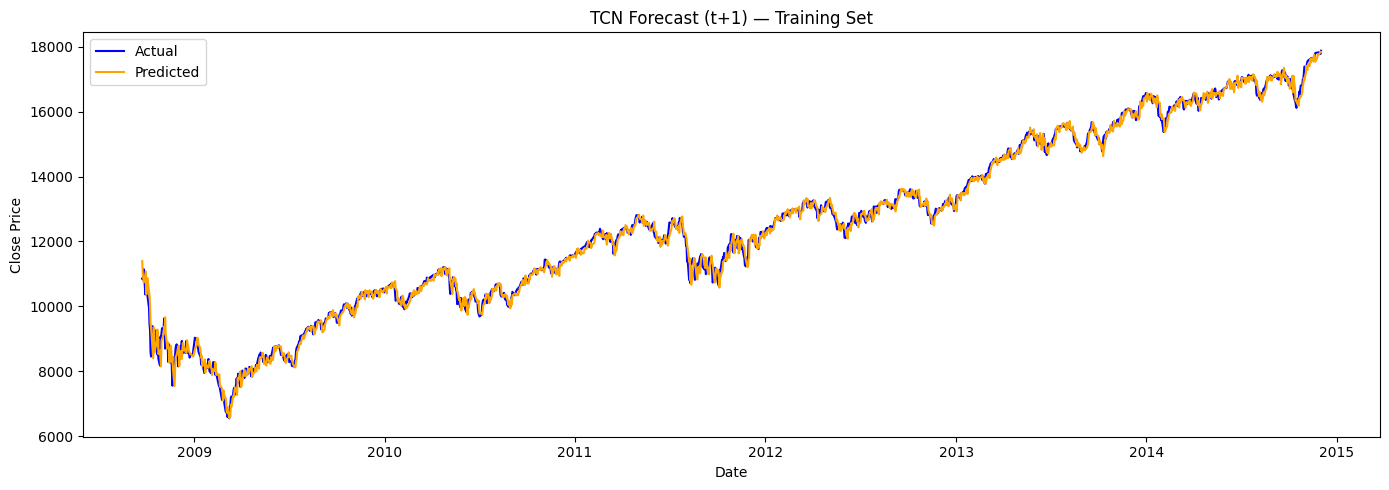


Training TCN model to predict Log Returns at t+3
Starting model.fit()
Epoch 1/50
44/44 - 4s - 98ms/step - loss: 0.5472 - val_loss: 0.0603
Epoch 2/50
44/44 - 0s - 10ms/step - loss: 0.4133 - val_loss: 0.0359
Epoch 3/50
44/44 - 0s - 10ms/step - loss: 0.3419 - val_loss: 0.0247
Epoch 4/50
44/44 - 0s - 10ms/step - loss: 0.2831 - val_loss: 0.0216
Epoch 5/50
44/44 - 0s - 10ms/step - loss: 0.2726 - val_loss: 0.0148
Epoch 6/50
44/44 - 0s - 10ms/step - loss: 0.2460 - val_loss: 0.0125
Epoch 7/50
44/44 - 0s - 10ms/step - loss: 0.2292 - val_loss: 0.0067
Epoch 8/50
44/44 - 0s - 10ms/step - loss: 0.2091 - val_loss: 0.0078
Epoch 9/50
44/44 - 0s - 10ms/step - loss: 0.2032 - val_loss: 0.0077
Epoch 10/50
44/44 - 0s - 10ms/step - loss: 0.1896 - val_loss: 0.0093
Epoch 11/50
44/44 - 0s - 10ms/step - loss: 0.1929 - val_loss: 0.0102
Epoch 12/50
44/44 - 0s - 10ms/step - loss: 0.1851 - val_loss: 0.0091
model.fit() complete
Saved model, scalers, and features for tcn_logret_tplus3
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9m

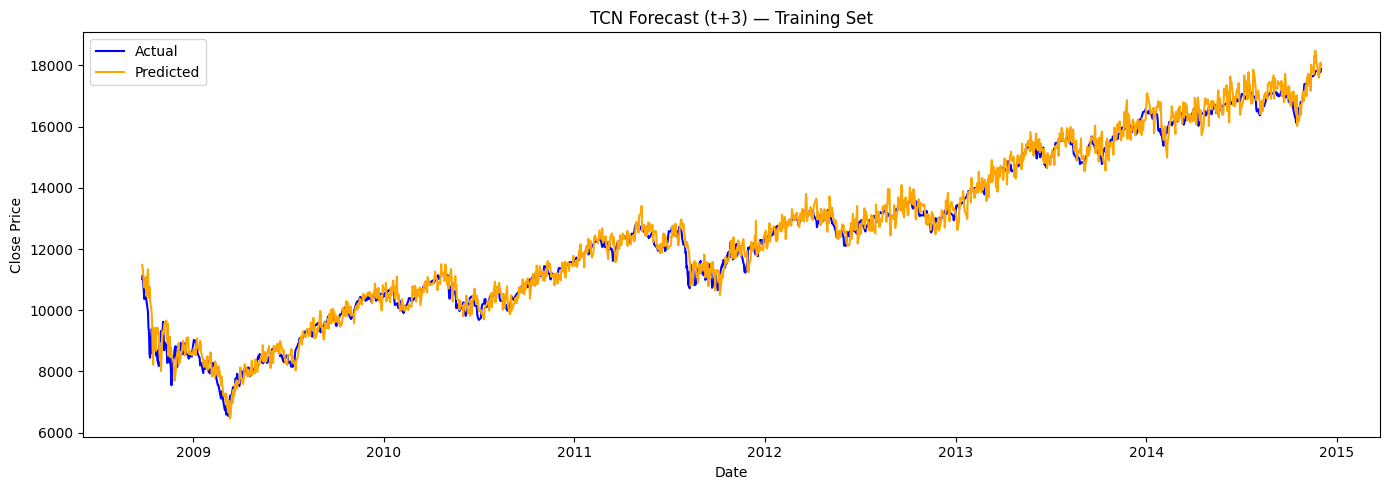


Training TCN model to predict Log Returns at t+7
Starting model.fit()
Epoch 1/50
44/44 - 4s - 99ms/step - loss: 0.4403 - val_loss: 0.1279
Epoch 2/50
44/44 - 0s - 10ms/step - loss: 0.3425 - val_loss: 0.0485
Epoch 3/50
44/44 - 0s - 10ms/step - loss: 0.3295 - val_loss: 0.0324
Epoch 4/50
44/44 - 0s - 11ms/step - loss: 0.2898 - val_loss: 0.0197
Epoch 5/50
44/44 - 0s - 10ms/step - loss: 0.2644 - val_loss: 0.0158
Epoch 6/50
44/44 - 0s - 10ms/step - loss: 0.2356 - val_loss: 0.0181
Epoch 7/50
44/44 - 0s - 10ms/step - loss: 0.2451 - val_loss: 0.0156
Epoch 8/50
44/44 - 0s - 10ms/step - loss: 0.2230 - val_loss: 0.0088
Epoch 9/50
44/44 - 0s - 10ms/step - loss: 0.2096 - val_loss: 0.0107
Epoch 10/50
44/44 - 0s - 11ms/step - loss: 0.1912 - val_loss: 0.0031
Epoch 11/50
44/44 - 0s - 10ms/step - loss: 0.1820 - val_loss: 0.0033
Epoch 12/50
44/44 - 0s - 10ms/step - loss: 0.1708 - val_loss: 0.0033
Epoch 13/50
44/44 - 0s - 10ms/step - loss: 0.1656 - val_loss: 0.0019
Epoch 14/50
44/44 - 0s - 11ms/step - loss

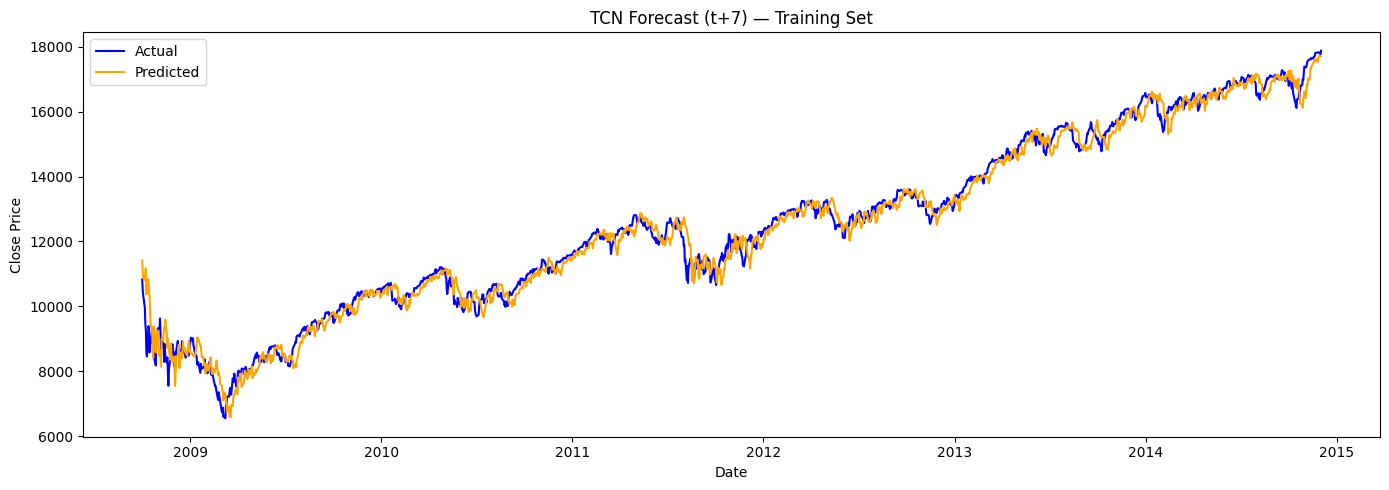

In [24]:
def train_tcn_logreturn_model(df_tcn_filtered, df_targets, forecast_horizon=1, window_size=30, epochs=50, batch_size=32):
    print(f"\nTraining TCN model to predict Log Returns at t+{forecast_horizon}")

    target_series = df_tcn_filtered['Log_Returns'].shift(-forecast_horizon).dropna()
    df_inputs = df_tcn_filtered.iloc[:len(target_series)]

    # Scaling
    X_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    X_scaled = X_scaler.fit_transform(df_inputs)
    y_scaled = y_scaler.fit_transform(target_series.values.reshape(-1, 1))

    # Sequences
    X_seq, y_seq = [], []
    for i in range(window_size, len(X_scaled)):
        X_seq.append(X_scaled[i - window_size:i])
        y_seq.append(y_scaled[i])
    X_seq, y_seq = np.array(X_seq), np.array(y_seq)

    assert len(X_seq) == len(y_seq), "Sequence and target length mismatch"

    # Build model
    model = Sequential()
    model.add(TCN(
        input_shape=(X_seq.shape[1], X_seq.shape[2]),
        nb_filters=32,
        kernel_size=2,
        dropout_rate=0.1,
    ))
    model.add(GroupNormalization(groups=8))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # Linear output
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=Huber())

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Fit model
    print("Starting model.fit()")
    model.fit(
        X_seq, y_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=2
    )
    print("model.fit() complete")

    # Save model & scalers
    model_name = f"tcn_logret_tplus{forecast_horizon}"
    base_path = "B:/DCU/Practicum/Proj/Models"
    os.makedirs(base_path, exist_ok=True)
    model.save(f"{base_path}/{model_name}.keras")
    joblib.dump(X_scaler, f"{base_path}/{model_name}_scalerX.pkl")
    joblib.dump(y_scaler, f"{base_path}/{model_name}_scalerY.pkl")
    joblib.dump(df_tcn_filtered.columns.tolist(), f"{base_path}/{model_name}_features.pkl")
    print(f"Saved model, scalers, and features for {model_name}")

    # Predict
    y_pred_scaled = model.predict(X_seq)
    y_pred_log = y_scaler.inverse_transform(y_pred_scaled).flatten()

    # clip predicted log returns to avoid exponential blowups
    y_pred_log = np.clip(y_pred_log, -0.15, 0.15)

    # Reconstruct close price
    close_start_idx = window_size - 1
    close_end_idx = close_start_idx + len(y_pred_log)
    close_t = df_targets['Close'].iloc[close_start_idx:close_end_idx].values

    assert len(close_t) == len(y_pred_log), "Mismatch: Close_t vs Predicted log returns"
    y_pred_close = close_t * np.exp(y_pred_log)

    # Actual Close at t+h
    y_true_close = df_targets['Close'].shift(-forecast_horizon).dropna().iloc[window_size:]
    y_true_close = y_true_close[:len(y_pred_close)].values

    date_series = multimodal['Date'].iloc[window_size + forecast_horizon: window_size + forecast_horizon + len(y_pred_close)]

    # Evaluation
    r2 = r2_score(y_true_close, y_pred_close)
    rmse = np.sqrt(mean_squared_error(y_true_close, y_pred_close))
    mae = mean_absolute_error(y_true_close, y_pred_close)
    print(f"TCN Train R²: {r2:.4f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

    # Save metrics
    metrics_path = os.path.join(base_path, f"{model_name}_metrics.txt")
    with open(metrics_path, "w") as f:
        f.write(f"Forecast Horizon = t+{forecast_horizon}\n")
        f.write(f"Train R²   = {r2:.4f}\n")
        f.write(f"Train RMSE = {rmse:.2f}\n")
        f.write(f"Train MAE  = {mae:.2f}\n")
    print(f"Saved training metrics to {metrics_path}")

    # Plot
    plt.figure(figsize=(14, 5))
    plt.plot(date_series, y_true_close, label='Actual', color='blue')
    plt.plot(date_series, y_pred_close, label='Predicted', color='orange')
    plt.title(f"TCN Forecast (t+{forecast_horizon}) — Training Set")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"B:/DCU/Practicum/Proj/Outputs/tcn_train_t_plus_{forecast_horizon}.png")
    plt.show()

    return model, {"r2": r2, "rmse": rmse, "mae": mae}

for h in [1, 3, 7]:
    clear_tf_memory()
    train_tcn_logreturn_model(df_tcn_filtered, df_targets, forecast_horizon=h)

<Axes: xlabel='Log_Returns', ylabel='Count'>

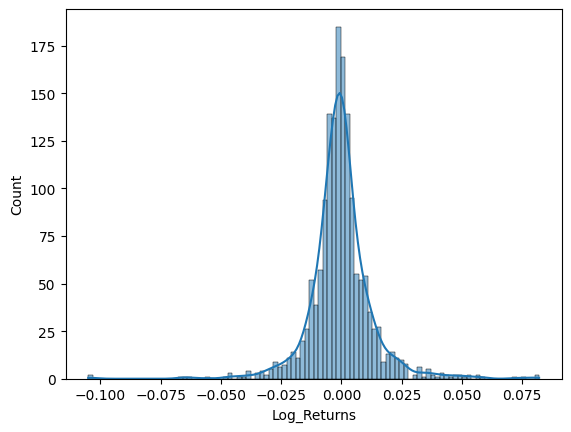

In [17]:
sns.histplot(df_tcn_filtered['Log_Returns'], bins=100, kde=True)

In [18]:
print("Skew:", skew(df_tcn_filtered['Log_Returns']))
print("Kurtosis:", kurtosis(df_tcn_filtered['Log_Returns']))

Skew: 0.06939321499881877
Kurtosis: 10.324332846429078


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


  0%|          | 0/25 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


  4%|▍         | 1/25 [00:13<05:18, 13.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


  8%|▊         | 2/25 [00:25<04:57, 12.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


 12%|█▏        | 3/25 [00:38<04:42, 12.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


 16%|█▌        | 4/25 [00:51<04:31, 12.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


 20%|██        | 5/25 [01:04<04:17, 12.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


 24%|██▍       | 6/25 [01:17<04:02, 12.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


 28%|██▊       | 7/25 [01:29<03:48, 12.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


 32%|███▏      | 8/25 [01:42<03:35, 12.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


 36%|███▌      | 9/25 [01:54<03:21, 12.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


 40%|████      | 10/25 [02:07<03:08, 12.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step


 44%|████▍     | 11/25 [02:22<03:08, 13.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


 48%|████▊     | 12/25 [02:35<02:53, 13.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


 52%|█████▏    | 13/25 [02:48<02:38, 13.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


 56%|█████▌    | 14/25 [03:01<02:24, 13.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


 60%|██████    | 15/25 [03:14<02:10, 13.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


 64%|██████▍   | 16/25 [03:27<01:56, 12.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


 68%|██████▊   | 17/25 [03:40<01:43, 12.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


 72%|███████▏  | 18/25 [03:52<01:30, 12.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


 76%|███████▌  | 19/25 [04:05<01:17, 12.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


 80%|████████  | 20/25 [04:18<01:04, 12.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


 84%|████████▍ | 21/25 [04:31<00:51, 12.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


 88%|████████▊ | 22/25 [04:44<00:38, 12.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


 92%|█████████▏| 23/25 [04:56<00:25, 12.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


 96%|█████████▌| 24/25 [05:10<00:13, 13.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


100%|██████████| 25/25 [05:23<00:00, 12.94s/it]


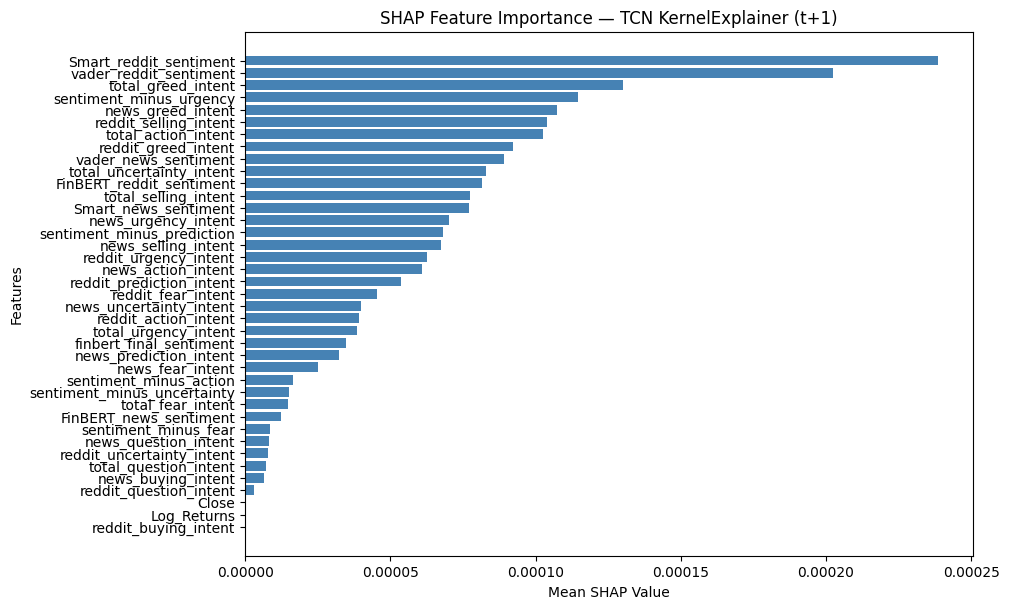

In [19]:
def run_shap_kernel_on_tcn(model_dir, df_input, forecast_horizon, window_size=30, num_samples=25):
    model_name = f"tcn_logret_tplus{forecast_horizon}"
    model_path = os.path.join(model_dir, f"{model_name}.keras")
    scalerX_path = os.path.join(model_dir, f"{model_name}_scalerX.pkl")

    # Load model and scaler
    model = load_model(model_path, compile=False)
    X_scaler = joblib.load(scalerX_path)

    # Scale and sequence input
    df_scaled = X_scaler.transform(df_input)
    X_seq = []
    for i in range(window_size, len(df_scaled)):
        X_seq.append(df_scaled[i - window_size:i])
    X_seq = np.array(X_seq)

    # Sample last N sequences
    X_sampled = X_seq[-num_samples:]

    # Track shape dimensions
    num_samples_actual = X_sampled.shape[0]
    num_timesteps = X_sampled.shape[1]
    num_features = X_sampled.shape[2]

    # Flatten input for KernelExplainer
    X_flat = X_sampled.reshape((num_samples_actual, num_timesteps * num_features))

    # Define prediction wrapper
    def predict_fn(x_flat):
        x_reshaped = x_flat.reshape((-1, num_timesteps, num_features))
        preds = model.predict(x_reshaped)
        return np.array(preds).astype(np.float64).reshape(-1, 1)

    # Run SHAP KernelExplainer
    explainer = shap.KernelExplainer(predict_fn, X_flat)
    try:
        shap_values = explainer(X_flat)
        with open(f"{model_name}_shap_dump.pkl", "wb") as f:
            joblib.dump(shap_values, f)
    except Exception as e:
        print(f"SHAP failed: {e}")
        return

    shap_array = np.abs(shap_values.values)  # shape: [samples, window_size * features]
    shap_array_3d = shap_array.reshape(shap_array.shape[0], window_size, num_features)
    shap_feature_mean = np.mean(shap_array_3d, axis=(0, 1))  # average across time and samples

    feature_names = df_input.columns.tolist()

    # Rank + plot
    shap_df = list(zip(feature_names, shap_feature_mean))
    shap_df.sort(key=lambda x: x[1], reverse=True)
    sorted_features, sorted_importance = zip(*shap_df)

    plt.figure(figsize=(10, 6))
    plt.barh(sorted_features[::-1], sorted_importance[::-1], color='steelblue')
    plt.title(f"SHAP Feature Importance — TCN KernelExplainer (t+{forecast_horizon})")
    plt.tight_layout()
    plt.xlabel("Mean SHAP Value")
    plt.ylabel("Features")
    plt.savefig(f"B:/DCU/Practicum/Proj/Outputs/{model_name}_shap_kernel.png")
    plt.show()

model_dir = "B:/DCU/Practicum/Proj/Models"

# for h in [1, 3, 7]:
#     print(f"\n Running SHAP KernelExplainer for TCN t+{h}")
#     run_shap_kernel_on_tcn(model_dir, df_tcn, forecast_horizon=h, num_samples=100)

run_shap_kernel_on_tcn(model_dir, df_tcn_filtered, forecast_horizon=1, num_samples=25)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


  0%|          | 0/25 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step


  4%|▍         | 1/25 [00:15<06:05, 15.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step


  8%|▊         | 2/25 [00:29<05:32, 14.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step


 12%|█▏        | 3/25 [00:42<05:09, 14.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step


 16%|█▌        | 4/25 [00:56<04:51, 13.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step


 20%|██        | 5/25 [01:09<04:34, 13.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step


 24%|██▍       | 6/25 [01:23<04:19, 13.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step


 28%|██▊       | 7/25 [01:36<04:04, 13.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step


 32%|███▏      | 8/25 [01:50<03:49, 13.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step


 36%|███▌      | 9/25 [02:03<03:35, 13.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


 40%|████      | 10/25 [02:16<03:20, 13.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


 44%|████▍     | 11/25 [02:29<03:06, 13.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


 48%|████▊     | 12/25 [02:43<02:53, 13.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


 52%|█████▏    | 13/25 [02:56<02:39, 13.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


 56%|█████▌    | 14/25 [03:09<02:25, 13.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step


 60%|██████    | 15/25 [03:22<02:12, 13.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step


 64%|██████▍   | 16/25 [03:36<02:00, 13.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


 68%|██████▊   | 17/25 [03:49<01:46, 13.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step


 72%|███████▏  | 18/25 [04:03<01:33, 13.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


 76%|███████▌  | 19/25 [04:16<01:20, 13.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step


 80%|████████  | 20/25 [04:30<01:07, 13.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


 84%|████████▍ | 21/25 [04:43<00:53, 13.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step


 88%|████████▊ | 22/25 [04:56<00:40, 13.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step


 92%|█████████▏| 23/25 [05:11<00:27, 13.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step


 96%|█████████▌| 24/25 [05:26<00:14, 14.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step


100%|██████████| 25/25 [05:41<00:00, 13.64s/it]


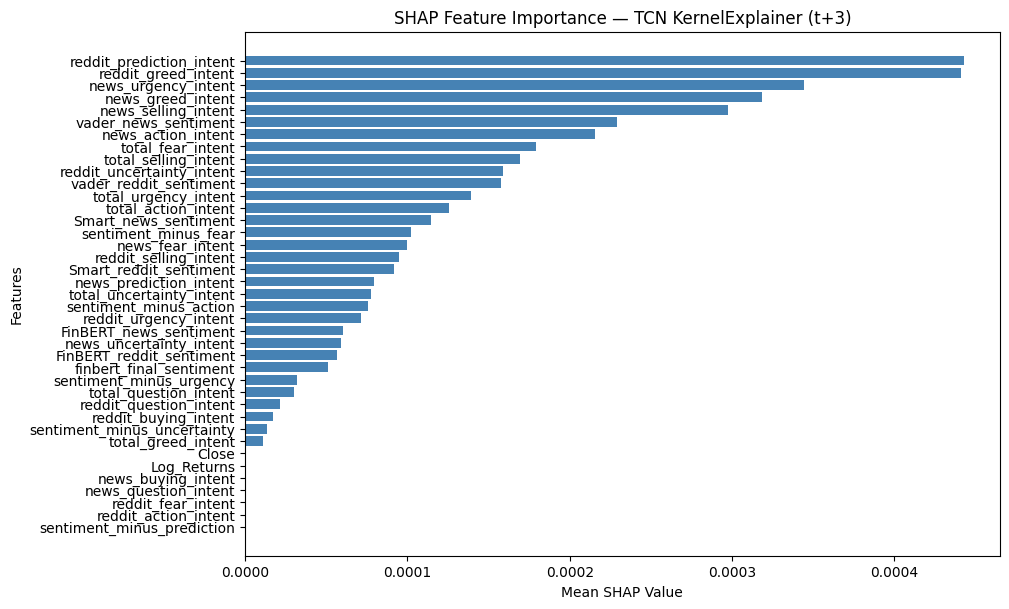

In [25]:
run_shap_kernel_on_tcn(model_dir, df_tcn_filtered, forecast_horizon=3, num_samples=25)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


  0%|          | 0/25 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step


  4%|▍         | 1/25 [00:14<05:54, 14.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step


  8%|▊         | 2/25 [00:29<05:37, 14.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step


 12%|█▏        | 3/25 [00:43<05:20, 14.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step


 16%|█▌        | 4/25 [00:58<05:05, 14.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step


 20%|██        | 5/25 [01:12<04:49, 14.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step


 24%|██▍       | 6/25 [01:27<04:34, 14.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step


 28%|██▊       | 7/25 [01:41<04:20, 14.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step


 32%|███▏      | 8/25 [01:55<04:05, 14.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step


 36%|███▌      | 9/25 [02:10<03:50, 14.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step


 40%|████      | 10/25 [02:24<03:35, 14.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step


 44%|████▍     | 11/25 [02:38<03:21, 14.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step


 48%|████▊     | 12/25 [02:53<03:07, 14.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step


 52%|█████▏    | 13/25 [03:07<02:53, 14.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step


 56%|█████▌    | 14/25 [03:22<02:39, 14.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step


 60%|██████    | 15/25 [03:37<02:25, 14.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step


 64%|██████▍   | 16/25 [03:52<02:12, 14.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


 68%|██████▊   | 17/25 [04:05<01:53, 14.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


 72%|███████▏  | 18/25 [04:18<01:36, 13.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


 76%|███████▌  | 19/25 [04:31<01:21, 13.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


 80%|████████  | 20/25 [04:44<01:06, 13.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


 84%|████████▍ | 21/25 [04:57<00:52, 13.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


 88%|████████▊ | 22/25 [05:09<00:39, 13.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


 92%|█████████▏| 23/25 [05:22<00:26, 13.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


 96%|█████████▌| 24/25 [05:35<00:13, 13.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3429/3429 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


100%|██████████| 25/25 [05:48<00:00, 13.95s/it]


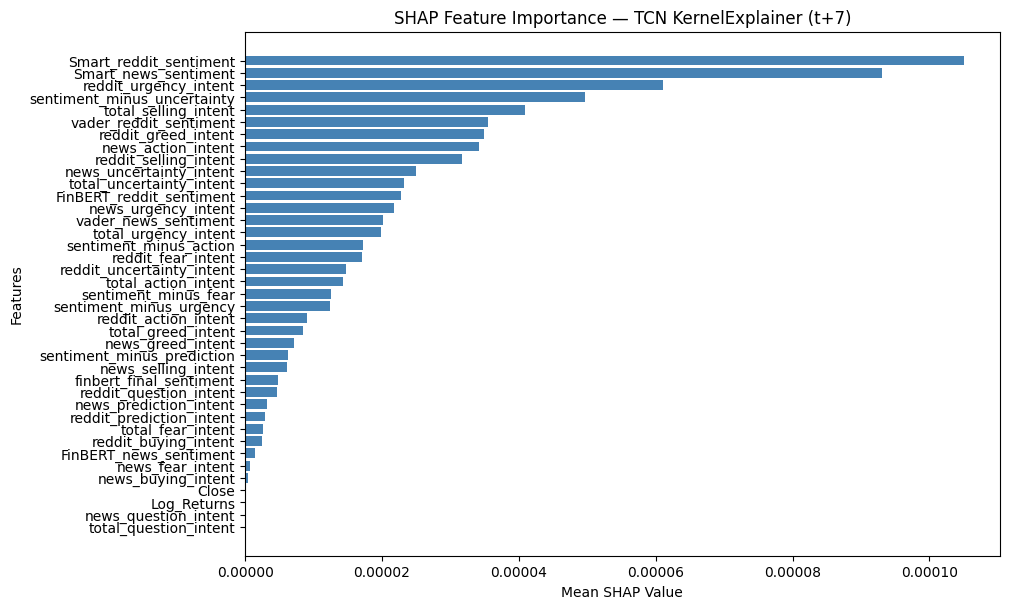

In [26]:
run_shap_kernel_on_tcn(model_dir, df_tcn_filtered, forecast_horizon=7, num_samples=25)